In [1]:
!ls

2016PresidentialPrep.ipynb      VA_Presidential_2016.csv
VA_Presidential2016_Cleaned.csv congressionalMapperHelp.ipynb


In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from shapely import wkt
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
pres = pd.read_csv("VA_Presidential2016_Cleaned.csv")
pres.drop(columns=["Unnamed: 0"], axis=1, inplace=True)
#pres.drop(index=0, inplace=True)
pres.head()

,County,Precinct Name,Precinct #,Hillary Clinton/Dem,Donald J. Trump/Rep,Gary Johnson/Lib,Jill Stein/Grn,Other/Other,Total Votes
0,Accomack County,Accomac,1,486,637,16,8,4,2328
1,Accomack County,Atlantic,2,175,553,13,1,1,1500
2,Accomack County,Bloxom,3,141,342,9,1,0,992
3,Accomack County,Bobtown,4,202,369,12,4,4,1188
4,Accomack County,Chincoteague,5,444,1188,26,7,5,3360


In [4]:
cong2016 = pd.read_csv("../congressional/congressional 2016/VA_Congressional_2016_Cleand.csv")
cong2018 = pd.read_csv("../congressional/congressional 2018/VA_Congressional_2018_Cleand.csv")

In [5]:
print(len(pres), len(cong2018))

2446 2748


# map congressional data to pres

In [6]:
cong2016.head(1)

,County/City,Pct,Republican,Democratic,Independent,Libertarian,Green,All Others,Total Votes Cast,dist_num,Type
0,Accomack County,101 - Chincoteague,1220,397,0,0,0,2.0,1619,2,CONG2016


In [7]:
cong2018.head(1)

,County/City,Pct,Republican,Democratic,Independent,Libertarian,Green,All Others,Total Votes Cast,dist_num,Type
0,Accomack County,101 - Chincoteague,974,465,0,0,0,1.0,1440,2,CONG2018


In [8]:
# delete this to clean pres
df = cong2018.copy()
df.rename(mapper={"County/City":"County","Pct":"Precinct #"}, inplace=True)
df["Ward"] = ""
df.drop(columns=["Type"], axis=1, inplace=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2748 entries, 0 to 2747
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   County/City       2748 non-null   object 
 1   Pct               2748 non-null   object 
 2   Republican        2748 non-null   int64  
 3   Democratic        2748 non-null   int64  
 4   Independent       2748 non-null   int64  
 5   Libertarian       2748 non-null   int64  
 6   Green             2748 non-null   int64  
 7   All Others        2748 non-null   float64
 8   Total Votes Cast  2748 non-null   int64  
 9   dist_num          2748 non-null   int64  
 10  Ward              2748 non-null   object 
dtypes: float64(1), int64(7), object(3)
memory usage: 257.6+ KB


## change column name

In [10]:
# rename columns
columns = {"County/City":"County", "Ward":"Precinct Name", "Pct":"Precinct #"}
df.rename(columns, axis=1, inplace=True)
df.head(1)

,County,Precinct #,Republican,Democratic,Independent,Libertarian,Green,All Others,Total Votes Cast,dist_num,Precinct Name
0,Accomack County,101 - Chincoteague,974,465,0,0,0,1.0,1440,2,


In [11]:
# convert voting columns to int type
def convert(df, mapper):
    m = {}
    for mm in mapper:
        m[mm] = "int"
        
    return df.astype(m)

mapper = ["Republican", "Democratic", "Independent", "Libertarian", "Green", "All Others", "Total Votes Cast", "dist_num"]
df = convert(df, mapper)

'''
presidential
mapper = {'Total Votes': 'int', "Hillary Clinton/Dem": 'int',
                "Donald J. Trump/Rep": "int", "Gary Johnson/Lib": "int",
                "Jill Stein/Grn": "int", "Other/Other":"int"}
df = convert(df, mapper)
'''
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2748 entries, 0 to 2747
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   County            2748 non-null   object
 1   Precinct #        2748 non-null   object
 2   Republican        2748 non-null   int64 
 3   Democratic        2748 non-null   int64 
 4   Independent       2748 non-null   int64 
 5   Libertarian       2748 non-null   int64 
 6   Green             2748 non-null   int64 
 7   All Others        2748 non-null   int64 
 8   Total Votes Cast  2748 non-null   int64 
 9   dist_num          2748 non-null   int64 
 10  Precinct Name     2748 non-null   object
dtypes: int64(8), object(3)
memory usage: 257.6+ KB


# try to fill in the precinct name column

In [12]:
# let fill in the precinct name column
'''
Rules:
    - if precinct # contains " - ", then split by it
    - if precinct # contains " ", last word will be precinct # others will be precinct name
    - else, if precinct # just 1 word, copy it to precinct name
'''
for index, row in df.iterrows():
    pName, pNum = "", ""
    cur_precinct = row["Precinct #"]
 
    if " - " in cur_precinct:
        pNum, pName = row["Precinct #"].rsplit(" - ", 1)
        df.at[index, "Precinct Name"] = pName
        df.at[index, "Precinct #"] = pNum
    elif " " in cur_precinct:
        pName, pNum = row["Precinct #"].rsplit(" ", 1)
        df.at[index, "Precinct Name"] = pName
        df.at[index, "Precinct #"] = pNum
    else:
        df.at[index, "Precinct Name"] = cur_precinct
    

In [13]:
df.head(1)

,County,Precinct #,Republican,Democratic,Independent,Libertarian,Green,All Others,Total Votes Cast,dist_num,Precinct Name
0,Accomack County,101,974,465,0,0,0,1,1440,2,Chincoteague


# loading precinct file

In [14]:
gdf = gpd.read_file("../../geographic/Precinct/vaprecincts2016.json")
gdf.head()

,Number,fips,ID,locality,precinct,geometry
0,623,51059,51059623,FAIRFAX COUNTY,ALBAN,"POLYGON ((-8594320.167 4686826.312, -8594307.6..."
1,626,51059,51059626,FAIRFAX COUNTY,SARATOGA,"POLYGON ((-8596198.040 4683632.983, -8596203.1..."
2,421,51059,51059421,FAIRFAX COUNTY,KINGSTOWNE,"POLYGON ((-8590092.883 4686148.765, -8590086.7..."
3,426,51059,51059426,FAIRFAX COUNTY,GREENSPRING,"POLYGON ((-8594759.444 4687621.588, -8594762.4..."
4,840,51059,51059840,FAIRFAX COUNTY,WEST SPRINGFIELD,"POLYGON ((-8594259.870 4689531.645, -8594259.0..."


In [15]:
'''
gdf.crs = {"init": "epsg:3857"}
gdf = gdf.to_crs({'init': 'epsg:4326'})
gdf.head()
'''

'\ngdf.crs = {"init": "epsg:3857"}\ngdf = gdf.to_crs({\'init\': \'epsg:4326\'})\ngdf.head()\n'

In [16]:
df_backup = df.copy()
gdf_backup = gdf.copy()

# try to map 2 df by county

In [17]:
df_counties = sorted(list(df["County"].unique()))
gdf_counties = sorted(list(gdf["locality"].unique()))

In [18]:
print(len(df_counties), len(gdf_counties))

133 133


In [19]:
def lc_helper(string):
    return string.lower().capitalize()

def lower_and_capitalize(df_county, gdf_county, df_precincts, gdf_precincts):
    df_county, gdf_county = lc_helper(df_county), lc_helper(gdf_county)
    df_precincts = [lc_helper(string) for string in df_precincts]
    gdf_precincts = [lc_helper(string) for string in gdf_precincts]
    
    return df_county, gdf_county, df_precincts, gdf_precincts

def compare_precinct(df_counties, gdf_counties):
    quit_flag = 0
    
    df_county = df_counties[working_num]
    gdf_county = gdf_counties[gdf_counties.index(df_county.upper())]
    
    df_precincts = sorted(list(df[df["County"] == df_county]["Precinct Name"]))
    gdf_precincts = sorted(list(gdf[gdf["locality"] == gdf_county]["precinct"]))
    
    # turn county and precinct name to lower and upper
    df_county, gdf_county, df_precincts, gdf_precincts = lower_and_capitalize(df_county, gdf_county, df_precincts, gdf_precincts)
    
    len1, len2 = len(df_precincts), len(gdf_precincts)
    zipped = list(zip(df_precincts, gdf_precincts))
    
    print("Current County:", df_county, gdf_county)
    print("Voting Precinct Num:", len1)
    print("Geographic Precinct Num:", len2)
    
    same = 1
    dif_tup = ""
    for tup in zipped:
        if tup[0] != tup[1]:
            same = 0
            dif_tup = tup
            break
    
    qutitator = "All" if same else "Not All"
    print(qutitator, "Precincts are same")
    
    if same == 0:
        print("Different Precinct:", dif_tup)
        quit_flag = 1
    
    return len1, len2, zipped, quit_flag

In [20]:
working_num = 24
num_counties = len(df_counties)
df_counties = sorted(list(df["County"].unique()))
gdf_counties = sorted(list(gdf["locality"].unique()))

while working_num != num_counties:
    len1, len2, zipped, quit_flag = compare_precinct(df_counties, gdf_counties)
    if quit_flag:
        print("Error num:", working_num)
        break
    working_num += 1
    print("\n")

Current County: Chesapeake city Chesapeake city
Voting Precinct Num: 70
Geographic Precinct Num: 63
Not All Precincts are same
Different Precinct: ('B m williams (cd 3)', 'B m williams')
Error num: 24


In [21]:
# print(zipped)

In [22]:
# helper cell block
'''
df_precincts = sorted(list(df[df["County"] == "Accomack County"]["Precinct Name"]))
gdf_precincts = sorted(list(gdf[gdf["locality"] == "ACCOMACK COUNTY"]["precinct"]))
def lc_helper(string):
    return string.lower().capitalize()

def lower_and_capitalize(df_precincts, gdf_precincts):
    df_precincts = [lc_helper(string) for string in df_precincts]
    gdf_precincts = [lc_helper(string) for string in gdf_precincts]
    
    return df_precincts, gdf_precincts

df_precincts, gdf_precincts = lower_and_capitalize(df_precincts, gdf_precincts)

not_in = []
for item in df_precincts:
    if item not in gdf_precincts:
        not_in.append(item)
print(not_in)
'''

'''
good_name = []
for p in df_precincts:
    if p in gdf_precincts:
        good_name.append(p)
print(good_name)

for p in good_name:
    gdf_precincts.remove(p)

good_name = []
for p in df_precincts:
    if p in gdf_precincts:
        good_name.append(p)
print(good_name)
'''

'\ngood_name = []\nfor p in df_precincts:\n    if p in gdf_precincts:\n        good_name.append(p)\nprint(good_name)\n\nfor p in good_name:\n    gdf_precincts.remove(p)\n\ngood_name = []\nfor p in df_precincts:\n    if p in gdf_precincts:\n        good_name.append(p)\nprint(good_name)\n'

## Operation to fix error from above

In [23]:
gdf = gdf_backup.copy()
df = df_backup.copy()

In [24]:
# drop duplicates in gdf
gdf.drop_duplicates(subset=["locality", "precinct", "Number", "fips", "ID"], keep = "first", inplace = True)

In [25]:
df[df["Precinct Name"] == "Nandua"]

,County,Precinct #,Republican,Democratic,Independent,Libertarian,Green,All Others,Total Votes Cast,dist_num,Precinct Name
11,Accomack County,701,830,714,0,0,0,1,1545,2,Nandua


In [26]:
# drop rows with precinct # not digit
# df = df[df["Precinct #"].str.isdigit()]

# drop all Central Absentee Precinct and Provisonal Precinct
drop_kw1 = 'Central Absentee Precinct'
drop_kw2 = 'Provisional'

df.drop(df[df["Precinct Name"].str.contains(drop_kw1)].index, inplace=True)
df.drop(df[df["Precinct Name"].str.contains(drop_kw2)].index, inplace=True)

'''
['Oak hall', 'Onancock', 'Onley'] not in df
['Nandua', 'New church'] not in gdf
'''
index1 = df[(df["County"] == "Accomack County") & (df["Precinct Name"] == "Nandua")].index
index2 = df[(df["County"] == "Accomack County") & (df["Precinct Name"] == 'New Church')].index
df.at[index1, "Precinct Name"] = "Oak hall"
df.at[index2, "Precinct Name"] = "Onancock"
# add Onley to df
columns = df.columns
row = [["Accomack County", 0, 0, 0, 0, 0, 0, 0, 0, -1, 'Onley']]
new_row = pd.DataFrame(row, columns=columns)
df = pd.concat([new_row, df], ignore_index=True)

# all precincts that contains (cd #), we drop this (cd #) part
for index, row in df.iterrows():
    precinct_name = row["Precinct Name"].split("(")[0].strip()
    df.at[index, "Precinct Name"] = precinct_name
# df[df["County"] == "Bedford County"]

In [27]:
'''
['Bacon/Saxe', 'County Seat', 'Cullen/Red House', 'Drakes Branch', 
'Keysville', 'Phenix', 'Red Oak Wylliesburg']

['BACON', 'COUNTY SEAT', 'CULLEN', 'DRAKES BRANCH', 'KEYSVILLE', 
'PHENIX', 'RED HOUSE', 'RED OAK WYLLIESBURG', 'SAXE']

voting data is missing 2 row, the missing row is same as ones that contains a /
'''
for index, row in df.iterrows():
    county = row["County"]
    precinct = row["Precinct Name"]
    if county == "Charlotte County" and '/' in precinct:
        name1, name2 = row["Precinct Name"].split("/")
        new_row = row
        new_row["Precinct Name"] = name2
        df.at[index, "Precinct Name"] = name1
        df = df.append(new_row, ignore_index=True)

for index, row in df.iterrows():
    county = row["County"]
    if county == "Charlotte County" and '/' in row["Precinct Name"]:
        precinct_name = row["Precinct Name"].split("/")[0].strip()
        df.at[index, "Precinct Name"] = precinct_name
        
# df[df["County"] == "Charlotte County"]

In [28]:
df.drop(df[(df["County"] == "Chesapeake City") & (df["Precinct Name"] == "Bacon")].index, inplace=True)

# E W Chittum and Jolliff precinct in Chesapeake county is splited to 2 row, merge them
precinct_name = ["E W Chittum", "Jolliff", "Sunray II"]

for p in precinct_name:
    p_rows = df[(df["County"] == "Chesapeake City") & (df["Precinct Name"] == p)]
    p_rows_group = p_rows.groupby(['County', "Precinct Name", "Precinct #"], as_index=False).sum()
    new_row = p_rows_group.take([0])
    # drop the duplicates
    df.drop(df[(df["County"] == "Chesapeake City") & (df["Precinct Name"] == p)].index, inplace=True)
    # add merged to df
    df = df.append(new_row, ignore_index=True)

# sunray Ii is empty
df.drop(df[(df["County"] == "Chesapeake City") & (df["Precinct Name"] == "Sunray Ii")].index, inplace=True)
# Westover = Taylor road
# index = df[(df["County"] == "Chesapeake City") & (df["Precinct Name"] == "Westover")].index
# df.at[index, "Precinct Name"] = "Taylor road"

In [29]:
# Fairfax County , Fairfax Station = Fairfax Court
# index = df[(df["County"] == "Fairfax County") & (df["Precinct Name"] == "Fairfax Station")].index
# df.at[index, "Precinct Name"] = "Fairfax court"

# true drops
index = df[(df["County"] == "Fairfax County") & (df["Precinct Name"] == "Greenway")].index
df.drop(index, inplace=True)

index = df[(df["County"] == "Fairfax County") & (df["Precinct Name"] == "Hughes")].index
df.drop(index, inplace=True)

index = df[(df["County"] == "Fairfax County") & (df["Precinct Name"] == "Rotonda")].index
df.drop(index, inplace=True)


# true opteration
# merge 2 Old mill
precinct_name = ["Old Mill", "Saint Albans"]

for p in precinct_name:
    p_rows = df[(df["County"] == "Fairfax County") & (df["Precinct Name"] == p)]
    p_rows_group = p_rows.groupby(['County', "Precinct Name", "Precinct #"], as_index=False).sum()
    new_row = p_rows_group.take([0])
    # drop the duplicates
    df.drop(df[(df["County"] == "Fairfax County") & (df["Precinct Name"] == p)].index, inplace=True)
    # add merged to df
    df = df.append(new_row, ignore_index=True)
    
# add new row precinct
precinct_name = ["Fairfax Court", "Graham-Greenway", "Terraset"]

for p in precinct_name:
    columns = df.columns
    row = [["Fairfax County", 0, 0, 0, 0, 0, 0, 0, 0, -1, p]]
    new_row = pd.DataFrame(row, columns=columns)
    df = pd.concat([new_row, df], ignore_index=True)

In [30]:
# (Fredericksburg city) gdf precinct name error, its in format of precinct 1 - precinct name. 
# split by - and keep the last element (Precinct Name)
for index, row in gdf.iterrows():
    county = row["locality"]
    if county == "FREDERICKSBURG CITY":
        _, precinct_name = row["precinct"].split("-")
        gdf.at[index, "precinct"] = precinct_name

In [31]:
# county: Hampton City, merge Tyler in df
p_rows = df[(df["County"] == "Hampton City") & (df["Precinct Name"] == "Tyler")]
p_rows_group = p_rows.groupby(["County", "Precinct Name", "Precinct #"], as_index=False).sum()
new_row = p_rows_group.take([0])
df.drop(p_rows.index, inplace=True)
df = df.append(new_row, ignore_index=True)

In [32]:
# South east = Southeast, gdf, Harrisonburg City
index = gdf[(gdf["locality"]=="HARRISONBURG CITY") & (gdf["precinct"]=="SOUTH EAST")].index
gdf.at[index, "precinct"] = "Southeast"

In [33]:
# temp, precinct Byrd, county Henrico County
precinct_name = ["Byrd"]

for p in precinct_name:
    columns = df.columns
    row = [["Henrico County", 0, 0, 0, 0, 0, 0, 0, 0, -1, p]]
    new_row = pd.DataFrame(row, columns=columns)
    df = pd.concat([new_row, df], ignore_index=True)

In [34]:
# true drop, Essex village and Quioccasin precinct from df
df.drop(df[(df["County"]=="Henrico County") & (df["Precinct Name"]=="Essex Village")].index, inplace=True)
df.drop(df[(df["County"]=="Henrico County") & (df["Precinct Name"]=="Quioccasin")].index, inplace=True)

In [35]:
# merge Dyers Store from Henry County
precinct_name = ["Dyers Store", "Mount Olivet"]

for p in precinct_name:
    p_rows = df[(df["County"] == "Henry County") & (df["Precinct Name"] == p)]
    p_rows_group = p_rows.groupby(['County', "Precinct Name", "Precinct #"], as_index=False).sum()
    new_row = p_rows_group.take([0])
    # drop the duplicates
    df.drop(df[(df["County"] == "Henry County") & (df["Precinct Name"] == p)].index, inplace=True)
    # add merged to df
    df = df.append(new_row, ignore_index=True)

In [36]:
# 104- berkeley in James city county is Berkeley d
index = df[(df["County"]=="James City County") & (df["Precinct Name"]=="104- Berkeley")].index
df.at[index, "Precinct Name"] = "Berkeley d"

In [37]:
# Lee = Newton - lee  in Loudoun county
index = df[(df["County"]=="Loudoun County") & (df["Precinct Name"]=="Lee")].index
df.at[index, "Precinct Name"] = "Newton - lee"
# Madison's trust = Old arcola vfd
index = df[(df["County"]=="Loudoun County") & (df["Precinct Name"]=="Madison's Trust")].index
df.at[index, "Precinct Name"] = "Old Arcola Vfd"

In [38]:
# 401- harmony = Harmony village in Middlesex County
index = df[(df["County"]=="Middlesex County") & (df["Precinct Name"]=="401- Harmony")].index
df.at[index, "Precinct Name"] = "Harmony Village"

In [39]:
# merge Granby in Norfolk City
precinct_name = ["Granby", "Titustown"]

for p in precinct_name:
    p_rows = df[(df["County"]=="Norfolk City") & (df["Precinct Name"]==p)]
    p_rows_group = p_rows.groupby(['County', "Precinct Name", "Precinct #"], as_index=False).sum()
    new_row = p_rows_group.take([0])
    # drop the duplicates
    df.drop(df[(df["County"] == "Norfolk City") & (df["Precinct Name"] == p)].index, inplace=True)
    # add merged to df
    df = df.append(new_row, ignore_index=True)

In [40]:
# 202- = Earskin in Pittsylvania County
index = df[(df["County"]=="Pittsylvania County") & (df["Precinct Name"]=="202-")].index
df.at[index, "Precinct Name"] = "Earskin"

In [41]:
# Portsmouth city, make all precinct in df same as that of gdf
new_zipped = [('33- Pinecrest Baptist', 'Eleven'),
 ('34- Churchland Branch', 'Even'),
 ('7- Park View Elementary', 'Five'),
 ('Cavalier Manor Recreation Center', 'Fourteen'),
 ('Churchland Elementary School', 'Hirty-four'),
 ('Churchland Middle School', 'Hirty-three'),
 ('Cradock Middle School', 'Nine'),
 ('Emanuel A. M. E. Church', 'Nineteen'),
 ('Emily N. Spong Preschool', 'One'),
 ('Fairview Heights Baptist Church', 'Seventeen'),
 ('Forward Church', 'Sixteen'),
 ('Grove Baptist Church', 'Ten'),
 ('Hampton Roads Community Health Center', 'Thirteen'),
 ('Hodges Manor Elementary School', 'Thirty'),
 ('John F. Kennedy Community Center', 'Thirty-eight'),
 ('John Tyler Elementary School', 'Thirty-five'),
 ('Lakeview Elementary School', 'Thirty-nine'),
 ('Mt. Hermon Village', 'Thirty-one'),
 ('Noble Street Baptist Church', 'Thirty-seven'),
 ('Port Norfolk Recreation Center', 'Thirty-six'),
 ('River Shore Baptist Church', 'Thirty-two'),
 ("Saint Andrew's United Methodist Church", 'Twenty'),
 ('Scottish Rite Temple', 'Twenty eight'),
 ('St. Mark Missionary Baptist Church', 'Twenty- nine'),
 ('The Rescue Church', 'Twenty-five'),
 ('Third Baptist Church', 'Twenty-four'),
 ('Victory Life Fellowship', 'Twenty-one'),
 ('West Park Church Of Christ', 'Twenty-seven'),
 ('Westhaven Baptist Church', 'Twenty-six'),
 ('Willett Hall', 'Twenty-three'),
 ('William E. Waters Middle School', 'Twenty-two')]

for tup in new_zipped:
    index = df[(df["County"]=="Portsmouth City") & (df["Precinct Name"]==tup[0])].index
    df.at[index, "Precinct Name"] = tup[1]

In [42]:
# drop ['Ben Lomond', 'Hampton', 'Tyler'] in Prince William County
to_drop = ['Ben Lomond', 'Hampton', 'Tyler']
for p in to_drop:
    index = df[(df["County"]=="Prince William County") & (df["Precinct Name"]==p)].index
    df.drop(index, inplace=True)

# merge ['Buckland mills', 'Burke-nickens', 'King', 'Penn', 'Triangle']
precinct_name = ['Buckland Mills', 'Burke-nickens', 'King', 'Penn', 'Triangle']

for p in precinct_name:
    p_rows = df[(df["County"]=="Prince William County") & (df["Precinct Name"]==p)]
    p_rows_group = p_rows.groupby(['County', "Precinct Name", "Precinct #"], as_index=False).sum()
    new_row = p_rows_group.take([0])
    # drop the duplicates
    df.drop(df[(df["County"] == "Prince William County") & (df["Precinct Name"] == p)].index, inplace=True)
    # add merged to df
    df = df.append(new_row, ignore_index=True)
    
# add new row Ashton
precinct_name = ["Ashton", "Godwin", "Haymarket"]

for p in precinct_name:
    columns = df.columns
    row = [["Prince William County", 0, 0, 0, 0, 0, 0, 0, 0, -1, p]]
    new_row = pd.DataFrame(row, columns=columns)
    df = pd.concat([new_row, df], ignore_index=True)

In [43]:
'''
Voting Precinct Num: 21
Geographic Precinct Num: 32
Need to create 11 more precinct in df
'''
for i in range(11):
    columns = df.columns
    row = [["Roanoke City", 0, 0, 0, 0, 0, 0, 0, 0, -1, "Unknown"]]
    new_row = pd.DataFrame(row, columns=columns)
    df = pd.concat([new_row, df], ignore_index=True)

# Roanoke City precinct fixing
other_gdf_precincts = ['Fishburn park', 'Highland 1', 'Highland 2', 'Jefferson 1', 'Jefferson 2', 'Jefferson-riverdale', 'Melrose', 'Monterey', 'Peters creek', 'Raleigh court 1', 'Raleigh court 2', 'Raleigh court 3', 'Raleigh court 4', 'Raleigh court 5', 'South roanoke 1', 'South roanoke 2', 'Tinker', 'Villa heights', 'Wasena', 'Washington heights', 'Westside', 'Williamson road 1', 'Williamson road 2', 'Williamson road 3', 'Williamson road 4', 'Williamson road 5', 'Williamson road 6']
good_precincts_2keep = ['Eureka Park', 'Garden City', 'Grandin Court', 'Lee-Hi', 'Lincoln Terrace']

# start filling in the precincts using gdf precincts
for index, row in df.iterrows():
    county = row["County"]
    precinct = row["Precinct Name"]
    if county == "Roanoke City" and precinct not in good_precincts_2keep and len(other_gdf_precincts):
        pop = other_gdf_precincts.pop()
        df.at[index, "Precinct Name"] = pop

In [44]:
# add Masons Valley in Roanoke County in df
columns = df.columns
row = [["Roanoke County", 0, 0, 0, 0, 0, 0, 0, 0, -1, "Masons Valley"]]
new_row = pd.DataFrame(row, columns=columns)
df = pd.concat([new_row, df], ignore_index=True)

In [45]:
# merge precincts from Spotsylvania County
precinct_name = ["Brents Mill", "Fairview", "Gayle", "Parkside", "Travelers Rest"]

for p in precinct_name:
    p_rows = df[(df["County"]=="Spotsylvania County") & (df["Precinct Name"]==p)]
    p_rows_group = p_rows.groupby(['County', "Precinct Name", "Precinct #"], as_index=False).sum()
    new_row = p_rows_group.take([0])
    # drop the duplicates
    df.drop(df[(df["County"] == "Spotsylvania County") & (df["Precinct Name"] == p)].index, inplace=True)
    # add merged to df
    df = df.append(new_row, ignore_index=True)

In [46]:
# merge precincts from Suffolk City
precinct_name = ["Booker T Washington", "John F Kennedy", "Lake Cohoon", "Olde Towne", "Southside"]

for p in precinct_name:
    p_rows = df[(df["County"]=="Suffolk City") & (df["Precinct Name"]==p)]
    p_rows_group = p_rows.groupby(['County', "Precinct Name", "Precinct #"], as_index=False).sum()
    new_row = p_rows_group.take([0])
    # drop the duplicates
    df.drop(df[(df["County"] == "Suffolk City") & (df["Precinct Name"] == p)].index, inplace=True)
    # add merged to df
    df = df.append(new_row, ignore_index=True)

In [47]:
# West Shenandoah = Town - West Shenandoah in Warren County
index = df[(df["County"]=="Warren County") & (df["Precinct Name"]=="West Shenandoah")].index
df.at[index, "Precinct Name"] = "Town - West Shenandoah"

In [48]:
# '204 woodland' = 'Odland hills ' in Washington County
index = df[(df["County"]=="Washington County") & (df["Precinct Name"]=="204 Woodland")].index
df.at[index, "Precinct Name"] = "Odland Hills"

In [49]:
# drop ['Precinct 2-2', 'Precinct 3-2'] in df not in gdf in Westmoreland County
to_drop = ['Precinct 2-2', 'Precinct 3-2']
indexs = df[(df["County"]=="Westmoreland County") & (df["Precinct Name"].isin(to_drop))].index
df.drop(indexs, inplace=True)

In [50]:
# 603 = Evergreen in Wythe County
index = df[(df["County"]=="Wythe County") & (df["Precinct Name"]=="603")].index
df.at[index, "Precinct Name"] = "Evergreen"

In [51]:
# Appomattox County,  Us  460 = Us 460 in gdf
index = gdf[(gdf["locality"]=="APPOMATTOX COUNTY") & (gdf["precinct"]=="US  460")].index
gdf.at[index, "precinct"] = "US 460"

# normalize precinct in gdf and precinct name in df

In [52]:
def normalize(string):
    string = string.strip()
    splited = string.split(" ")
    for i in range(len(splited)):
        splited[i] = splited[i].lower().capitalize().strip()
    return ' '.join(splited).strip()

In [53]:
for index, row in df.iterrows():
    npname = normalize(row["Precinct Name"])
    df.at[index, "Precinct Name"] = npname

In [54]:
for index, row in gdf.iterrows():
    npname = normalize(row["precinct"])
    gdf.at[index, "precinct"] = npname

# run test again

In [55]:
working_num = 0
num_counties = len(df_counties)
df_counties = sorted(list(df["County"].unique()))
gdf_counties = sorted(list(gdf["locality"].unique()))

while working_num != num_counties:
    len1, len2, zipped, quit_flag = compare_precinct(df_counties, gdf_counties)
    if quit_flag:
        print("Error num:", working_num)
        break
    working_num += 1
    print("\n")

Current County: Accomack county Accomack county
Voting Precinct Num: 17
Geographic Precinct Num: 17
All Precincts are same


Current County: Albemarle county Albemarle county
Voting Precinct Num: 28
Geographic Precinct Num: 28
All Precincts are same


Current County: Alexandria city Alexandria city
Voting Precinct Num: 27
Geographic Precinct Num: 27
All Precincts are same


Current County: Alleghany county Alleghany county
Voting Precinct Num: 12
Geographic Precinct Num: 12
All Precincts are same


Current County: Amelia county Amelia county
Voting Precinct Num: 5
Geographic Precinct Num: 5
All Precincts are same


Current County: Amherst county Amherst county
Voting Precinct Num: 11
Geographic Precinct Num: 11
All Precincts are same


Current County: Appomattox county Appomattox county
Voting Precinct Num: 9
Geographic Precinct Num: 9
All Precincts are same


Current County: Arlington county Arlington county
Voting Precinct Num: 52
Geographic Precinct Num: 52
All Precincts are same




Geographic Precinct Num: 6
All Precincts are same


Current County: Norton city Norton city
Voting Precinct Num: 1
Geographic Precinct Num: 1
All Precincts are same


Current County: Nottoway county Nottoway county
Voting Precinct Num: 9
Geographic Precinct Num: 9
All Precincts are same


Current County: Orange county Orange county
Voting Precinct Num: 10
Geographic Precinct Num: 10
All Precincts are same


Current County: Page county Page county
Voting Precinct Num: 5
Geographic Precinct Num: 5
All Precincts are same


Current County: Patrick county Patrick county
Voting Precinct Num: 13
Geographic Precinct Num: 13
All Precincts are same


Current County: Petersburg city Petersburg city
Voting Precinct Num: 7
Geographic Precinct Num: 7
All Precincts are same


Current County: Pittsylvania county Pittsylvania county
Voting Precinct Num: 29
Geographic Precinct Num: 29
All Precincts are same


Current County: Poquoson city Poquoson city
Voting Precinct Num: 3
Geographic Precinct Num: 3
A

# normalizing Precinct # in df

In [56]:
df.sort_values(by=["County", "Precinct Name"], inplace = True, ignore_index=True)
df.head(2)

,County,Precinct #,Republican,Democratic,Independent,Libertarian,Green,All Others,Total Votes Cast,dist_num,Precinct Name
0,Accomack County,601,533,407,0,0,0,0,940,2,Accomac
1,Accomack County,201,452,149,0,0,0,2,603,2,Atlantic


In [57]:
num = 1
for index, row in df.iterrows():
    i = str(num)
    if len(i) == 1:
        i = "000" + i
    elif len(i) == 2:
        i = "00" + i
    elif len(i) == 3:
        i = "0" + i
    df.at[index, "Precinct #"] = i
    num += 1
df.head()

,County,Precinct #,Republican,Democratic,Independent,Libertarian,Green,All Others,Total Votes Cast,dist_num,Precinct Name
0,Accomack County,0001,533,407,0,0,0,0,940,2,Accomac
1,Accomack County,0002,452,149,0,0,0,2,603,2,Atlantic
2,Accomack County,0003,268,103,0,0,0,0,371,2,Bloxom
3,Accomack County,0004,337,193,0,0,0,0,530,2,Bobtown
4,Accomack County,0005,974,465,0,0,0,1,1440,2,Chincoteague


In [58]:
df.to_csv("../congressional/congressional 2018/VA_Congressional2018_Cleaned_Mapped.csv")

# normalize gdf county

In [59]:
gdf.head(2)

,Number,fips,ID,locality,precinct,geometry
0,623,51059,51059623,FAIRFAX COUNTY,Alban,"POLYGON ((-8594320.167 4686826.312, -8594307.6..."
1,626,51059,51059626,FAIRFAX COUNTY,Saratoga,"POLYGON ((-8596198.040 4683632.983, -8596203.1..."


In [60]:
def normalize_county(string):
    splited = string.split(" ")
    for i in range(len(splited)):
        splited[i] = splited[i].strip().lower().capitalize()
    return ' '.join(splited)

In [61]:
for index, row in gdf.iterrows():
    gdf.at[index, "locality"] = normalize_county(row["locality"])

In [62]:
gdf.head(2)

,Number,fips,ID,locality,precinct,geometry
0,623,51059,51059623,Fairfax County,Alban,"POLYGON ((-8594320.167 4686826.312, -8594307.6..."
1,626,51059,51059626,Fairfax County,Saratoga,"POLYGON ((-8596198.040 4683632.983, -8596203.1..."


In [63]:
d = sorted(list(df["County"].unique()))
g = sorted(list(gdf["locality"].unique()))
zipped = list(zip(d,g))
for tup in zipped:
    if tup[0] != tup[1]:
        print(tup)

('Isle of Wight County', 'Isle Of Wight County')
('King George County', 'King And Queen County')
('King William County', 'King George County')
('King and Queen County', 'King William County')


In [64]:
# fix these in gdf
mapper = {'Isle Of Wight County': 'Isle of Wight County', 
          'King And Queen County':"King and Queen County"}

for index, row in gdf.iterrows():
    county = row["locality"]
    if county in mapper.keys():
        gdf.at[index, "locality"] = mapper[county]

In [65]:
# test again
d = sorted(list(df["County"].unique()))
g = sorted(list(gdf["locality"].unique()))
zipped = list(zip(d,g))
for tup in zipped:
    if tup[0] != tup[1]:
        print(tup)

In [66]:
name = {"Number":"Precinct #", "locality":"County", "precinct":"Precinct Name"}
gdf.rename(name, inplace=True, axis=1)
gdf.sort_values(by=["County", "Precinct Name"], inplace = True, ignore_index=True)
gdf.head(1)

,Precinct #,fips,ID,County,Precinct Name,geometry
0,601,51001,51001601,Accomack County,Accomac,"POLYGON ((-8422691.714 4547060.345, -8422703.9..."


In [67]:
# some precinct # is ""
index = gdf[gdf["Precinct #"] == ""].index

In [68]:
precinctNum = 3000
for i in index:
    gdf.at[i, "Precinct #"] = str(precinctNum)
    precinctNum += 1

In [69]:
gdf.at[1993, "Precinct #"] = "1033"

In [70]:
# gdf.to_file("../../geographic/Precinct/VA_Precinct_Cleaned.GeoJSON", driver="GeoJSON")

# map voting to geo, precinct name is 1 to 1 in both, county is 1 to 1 in both too, create cname to merge

In [71]:
# gdf = gpd.read_file("../../geographic/Precinct/VA_Precinct_Cleaned.GeoJSON")
# gdf.head(1)

In [72]:
gdfcopy = gdf.copy()
dfcopy = df.copy()

In [73]:
df = dfcopy.copy()
gdf = gdfcopy.copy()
dfs = [df, gdf]
for d in dfs:
    d["CName"] = ""
    for index, row in d.iterrows():
        cur_county = row["County"].lower()
        precinct_name = row["Precinct Name"]
        d.at[index, "CName"] = cur_county + "-" + precinct_name
        # precinct_num += 1

In [74]:
print(len(df), len(gdf), len(df["CName"].unique()), len(gdf["CName"].unique()))

2446 2446 2445 2445


In [75]:
columns = list(gdf.columns)
columns.remove("geometry")
gdf[gdf.duplicated("CName")]

,Precinct #,fips,ID,County,Precinct Name,geometry,CName
920,401,51630,51630401,Fredericksburg City,District Four,"POLYGON ((-8622994.774 4622303.527, -8622600.2...",fredericksburg city-District Four


In [76]:
columns = list(df.columns)
df[df.duplicated("CName")]

,County,Precinct #,Republican,Democratic,Independent,Libertarian,Green,All Others,Total Votes Cast,dist_num,Precinct Name,CName
920,Fredericksburg City,0921,217,521,0,0,0,0,738,1,District Four,fredericksburg city-District Four


In [77]:
gdf[gdf["CName"] == "fredericksburg city-District Four"]

,Precinct #,fips,ID,County,Precinct Name,geometry,CName
919,402,51630,51630402,Fredericksburg City,District Four,"POLYGON ((-8623524.718 4623367.945, -8623410.2...",fredericksburg city-District Four
920,401,51630,51630401,Fredericksburg City,District Four,"POLYGON ((-8622994.774 4622303.527, -8622600.2...",fredericksburg city-District Four


In [78]:
g1, g2 = gdf[gdf["CName"] == "fredericksburg city-District Four"].loc[919], gdf[gdf["CName"] == "fredericksburg city-District Four"].loc[920]

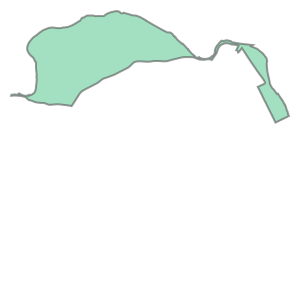

In [79]:
g1["geometry"]

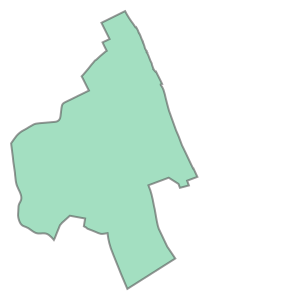

In [80]:
g2["geometry"]

In [81]:
df[df["CName"] == "fredericksburg city-District Four"]

,County,Precinct #,Republican,Democratic,Independent,Libertarian,Green,All Others,Total Votes Cast,dist_num,Precinct Name,CName
919,Fredericksburg City,0920,263,948,0,0,0,5,1216,1,District Four,fredericksburg city-District Four
920,Fredericksburg City,0921,217,521,0,0,0,0,738,1,District Four,fredericksburg city-District Four


In [82]:
# change index 920 in gdf and df to Precinct Name District 920
df.at[920, "Precinct Name"] = "District 920"
gdf.at[920, "Precinct Name"] = "District 920"

In [83]:
df.drop(["CName"], axis=1, inplace=True)
gdf.drop(["CName"], axis=1, inplace=True)
df.head(1)

,County,Precinct #,Republican,Democratic,Independent,Libertarian,Green,All Others,Total Votes Cast,dist_num,Precinct Name
0,Accomack County,0001,533,407,0,0,0,0,940,2,Accomac


In [84]:
# save the newer version
# df.to_csv("VA_Presidential2016_Cleaned.csv")
# gdf.to_file("../../geographic/Precinct/VA_Precinct_Cleaned.GeoJSON", driver="GeoJSON")

In [85]:
dfcopy = df.copy()
gdfcopy = gdf.copy()

In [86]:
df = dfcopy.copy()
gdf = gdfcopy.copy()
dfs = [df, gdf]
for d in dfs:
    d["CName"] = ""
    for index, row in d.iterrows():
        cur_county = row["County"].lower()
        precinct_name = row["Precinct Name"]
        d.at[index, "CName"] = cur_county + "-" + precinct_name
        # precinct_num += 1

print(len(df), len(gdf), len(df["CName"].unique()), len(gdf["CName"].unique()))

2446 2446 2446 2446


# merge on CName

In [87]:
gdf.head(1)

,Precinct #,fips,ID,County,Precinct Name,geometry,CName
0,601,51001,51001601,Accomack County,Accomac,"POLYGON ((-8422691.714 4547060.345, -8422703.9...",accomack county-Accomac


In [88]:
gdf.drop(["Precinct #", "fips", "ID", "County", "Precinct Name"], axis=1, inplace=True)
gdf.sort_values(by=["CName"], inplace = True, ignore_index=True)
gdf.head(1)

,geometry,CName
0,"POLYGON ((-8422691.714 4547060.345, -8422703.9...",accomack county-Accomac


In [89]:
df.sort_values(by=["CName"], inplace = True, ignore_index=True)
df.head(1)

,County,Precinct #,Republican,Democratic,Independent,Libertarian,Green,All Others,Total Votes Cast,dist_num,Precinct Name,CName
0,Accomack County,0001,533,407,0,0,0,0,940,2,Accomac,accomack county-Accomac


In [90]:
# merging
merged = gdf.merge(df, left_on='CName', right_on='CName')

In [91]:
merged.head(1)

,geometry,CName,County,Precinct #,Republican,Democratic,Independent,Libertarian,Green,All Others,Total Votes Cast,dist_num,Precinct Name
0,"POLYGON ((-8422691.714 4547060.345, -8422703.9...",accomack county-Accomac,Accomack County,0001,533,407,0,0,0,0,940,2,Accomac


In [92]:
print(len(merged), len(merged["CName"].unique()))

2446 2446


In [93]:
# merged.to_file("../../VA_Precinct_Merged.GeoJSON", driver="GeoJSON")
merged.to_file("../congressional/congressional 2018/VA_Precinct_Cong2018_Merged.json", driver="GeoJSON")

In [94]:
#merged.plot(figsize=(18, 10))

In [95]:
# precinct = gpd.read_file("../../geographic/Precinct/VA_Precinct_Cleaned.GeoJSON")

In [96]:
# precinct.plot()